In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os, random
import sys
sys.path.append('../')
import astropy

from data import KMTData
from data import OGLEData

random.seed(42)

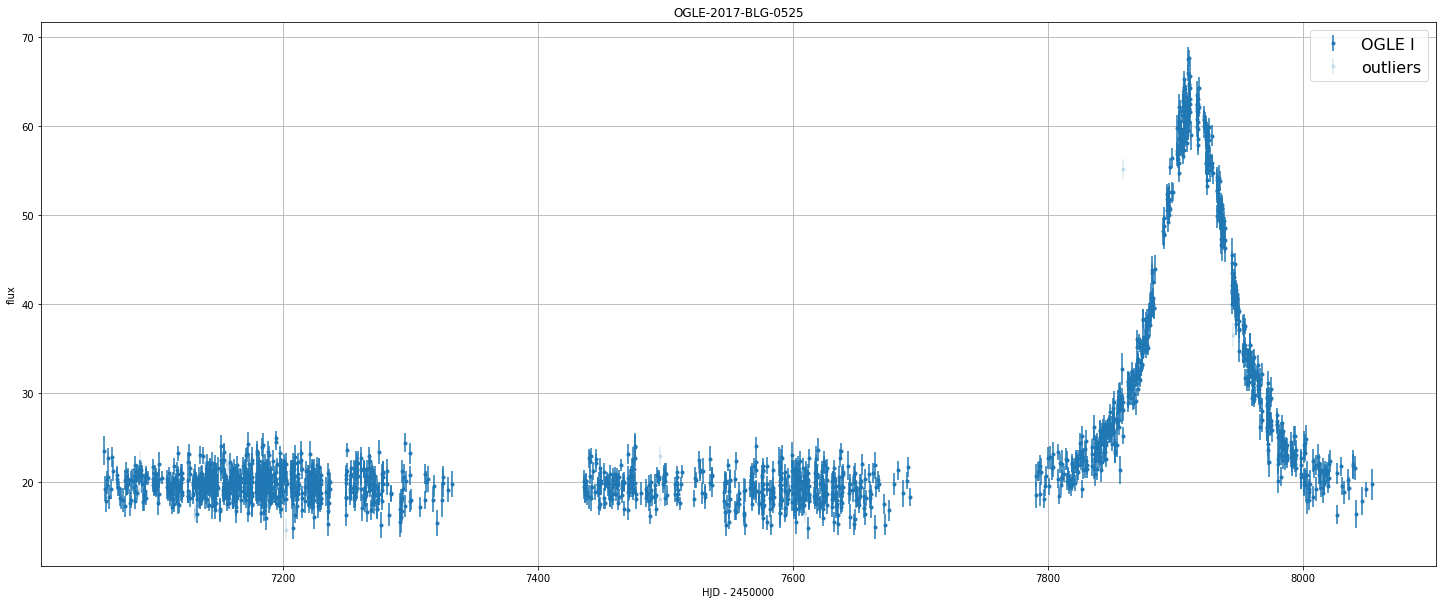

In [2]:
event = OGLEData('/home/star/fb90/data/OGLE_ews/2017/blg-0525')
fig, ax = plt.subplots(figsize=(25, 10))
event.remove_worst_outliers(window_size=11, mad_cutoff=7)
event.plot(ax)

# Query JPL horizons and get Eath's orbital elements for each $t_i$


In [3]:
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u

start = Time(event.tables[0]['HJD'][0], format='jd')
stop = Time(event.tables[0]['HJD'][-1], format='jd')

epochs={'start':start.iso[:10], 'stop':stop.iso[:10], 'step':'6h'}
obj = Horizons(id='399', id_type='id', epochs=epochs)

In [4]:
elements = obj.elements()
elements

targetname,datetime_jd,datetime_str,e,q,incl,Omega,w,Tp_jd,n,M,nu,a,Q,P
---,d,---,---,AU,deg,deg,deg,d,deg / d,deg,deg,AU,AU,d
str11,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Earth (399),2457059.5,A.D. 2015-Feb-06 00:00:00.0000,0.016147432121,0.98307241715,0.00110079000079,236.758073225,224.413210897,2457024.62189,0.986782627227,34.4171132974,35.4805970272,0.999207045085,1.01534167302,364.821988214
Earth (399),2457059.75,A.D. 2015-Feb-06 06:00:00.0000,0.0161729737979,0.983064368582,0.00111173642612,239.57215165,221.577261882,2457024.60107,0.986756318928,34.683433075,35.7557832908,0.999224805175,1.01538524177,364.831714877
Earth (399),2457060.0,A.D. 2015-Feb-06 12:00:00.0000,0.0161997945326,0.983056870844,0.0011237940887,242.088006338,219.045007888,2457024.58563,0.986727256806,34.9443230434,36.0254796388,0.99924442522,1.0154319796,364.842460281
Earth (399),2457060.25,A.D. 2015-Feb-06 18:00:00.0000,0.0162278265688,0.983049952662,0.00113627998843,244.307897224,216.814235136,2457024.57563,0.986695499612,35.1997407225,36.289639978,0.999265865829,1.015481779,364.854202884
Earth (399),2457060.5,A.D. 2015-Feb-07 00:00:00.0000,0.0162570011493,0.983043641686,0.00114858835185,246.237638906,214.879162875,2457024.57109,0.98666110925,35.4496558615,36.5482305122,0.999289085498,1.01553452931,364.866919984
Earth (399),2457060.75,A.D. 2015-Feb-07 06:00:00.0000,0.0162872486222,0.98303796446,0.00116019409918,247.88490719,213.232137335,2457024.57204,0.986624150648,35.6940499616,36.8012292618,0.999314040693,1.01559011693,364.880587774
Earth (399),2457061.0,A.D. 2015-Feb-07 12:00:00.0000,0.0163184985241,0.983032946411,0.00117065299173,249.257892299,211.864978987,2457024.57848,0.986584691658,35.9329157949,37.0486255774,0.99934068592,1.01564842543,364.895181371
Earth (399),2457061.25,A.D. 2015-Feb-07 18:00:00.0000,0.0163506796416,0.983028611838,0.00117959993007,250.364280916,210.770000989,2457024.59041,0.986542802978,36.1662569314,37.2904196616,0.999368973772,1.01570933571,364.910674847


In [5]:
def equatorial_to_ecliptic_coordinates(coordinates, obs_time):
    # Earth's obliquity angle
    T = (obs_time - 2451545)/365.25/100 # julian centuries since J2000
    eps = 23.439279 - (46.815/60**2)*T
    R = np.array([[1, 0, 0],
                   [0, np.cos(eps), np.sin(eps)],
                   [0, -np.sin(eps), np.cos(eps)]])
    
    ra = coordinates.ra.to(u.rad).value
    dec = coordinates.dec.to(u.rad).value
    coord_ec_cartesian = np.array([np.cos(ra)*np.cos(dec),
                                   np.sin(ra)*np.cos(dec),
                                   np.sin(dec)])
    
    # Transformation between equatorial and ecliptical coordinates
    coord_eq_cartesian = R @ coord_ec_cartesian[:, np.newaxis]
    
    b = np.arcsin(coord_eq_cartesian[2])
    l = 2*np.arctan(coord_eq_cartesian[1]/(np.cos(b) + coord_eq_cartesian[0]))
    
    return {'l':l, 'b':b}


# Calculate $\gamma_n(t)$ and $\gamma_w(t)$

In [6]:
event_ecl_coord = equatorial_to_ecliptic_coordinates(event.coordinates, 0.5*(event.tables[0]['HJD'][0] + event.tables[0]['HJD'][-1]))
lambda_0  = event_ecl_coord['l']
beta_0  = event_ecl_coord['b']

t = np.array(elements['datetime_jd']) # JD
e = np.array(elements['e'])
tp = np.array(elements['Tp_jd']) # JD
n = (2*np.pi/365.25) # mean motion
Phi_gamma = (77.86)*np.pi/180 # true anomaly at vernal eq. on J2000
r_sun = 1 - e*np.cos(n*(t - tp)) # to 1st order in e
lambda_sun = n*(t - tp) - Phi_gamma + 2*e*np.sin(n*(t - tp)) # to 1st order in e

gamma_w = r_sun*np.sin((lambda_sun - lambda_0))
gamma_n = r_sun*np.sin(beta_0)*np.cos(lambda_sun - lambda_0)

gamma_w_dot = n*((1 + e*np.cos(n*(t - tp)))*np.cos(lambda_sun - lambda_0)+\
    e*np.sin(n*(t - tp))*np.sin(lambda_sun - lambda_0))
gamma_n_dot = -n*np.sin(beta_0)*((1 + e*np.cos(n*(t - tp)))*np.sin(lambda_sun - lambda_0) -\
    e*np.sin(n*(t - tp))*np.cos(lambda_sun - lambda_0))

gamma_w_ddot = -n**2*(1 + 2*e*np.cos(n*(t - tp)))*np.sin(lambda_sun - lambda_0)
gamma_n_ddot = -n**2*np.sin(beta_0)*(1 + 2*e*np.cos(n*(t - tp)))*np.cos(lambda_sun - lambda_0)

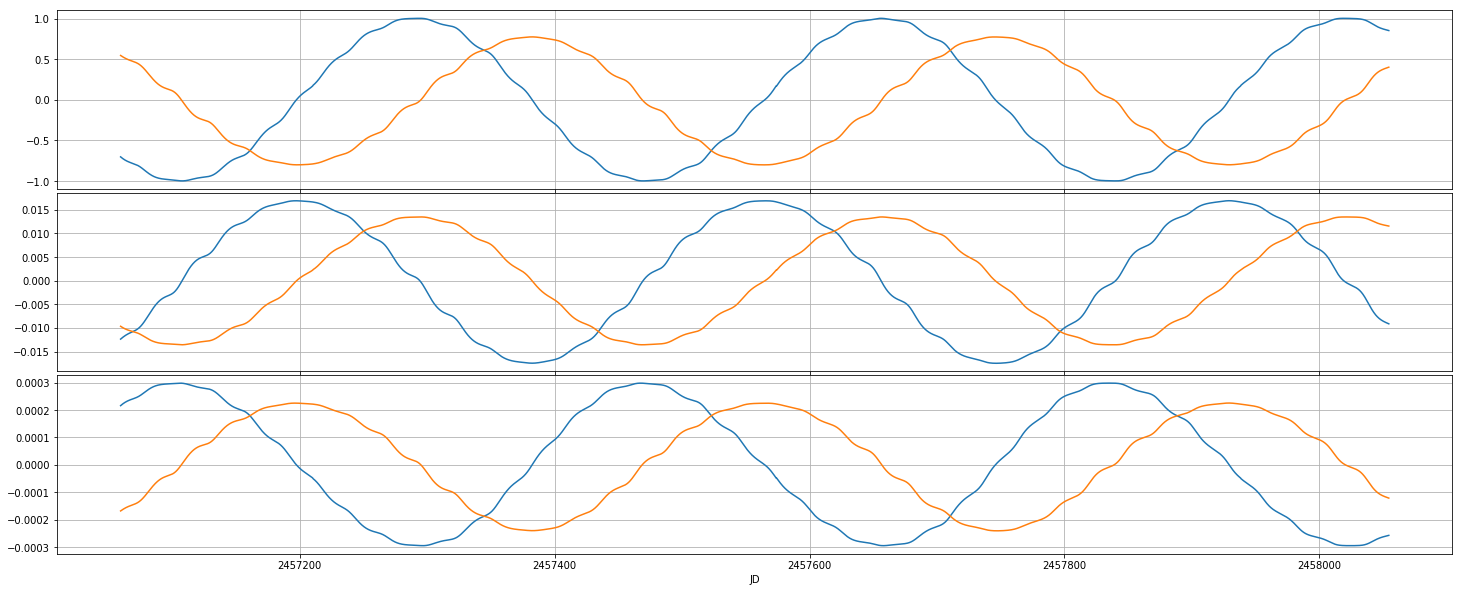

In [7]:
fig, ax = plt.subplots(3,1, figsize=(25, 10), sharex=True)
fig.subplots_adjust(hspace=0.02)
ax[0].plot(t, gamma_w, 'C0', label='gamma_w')
ax[0].plot(t, gamma_n, 'C1', label='gamma_n')
ax[1].plot(t, gamma_w_dot, 'C0', label='gamma_w_dot')
ax[1].plot(t, gamma_n_dot, 'C1', label='gamma_n_dot')
ax[2].plot(t, gamma_w_ddot, 'C0', label='gamma_w_ddot')
ax[2].plot(t, gamma_n_ddot, 'C1', label='gamma_n_ddot')
ax[2].set_xlabel('JD')
for a in ax.ravel():
    a.grid()

In [8]:
np.interp(event.tables[0]['HJD'], t, gamma_w)

array([-0.7063385 , -0.71862763, -0.71881728, ...,  0.89204122,
        0.87405406,  0.85204442])

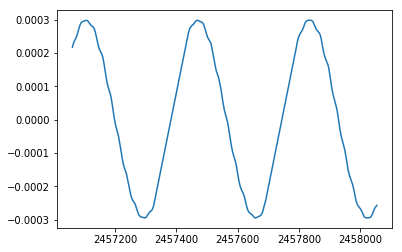

In [9]:
plt.plot(event.tables[0]['HJD'], np.interp(event.tables[0]['HJD'], t, gamma_w_ddot))

# Interpolation in PyMC3

In [10]:
import exoplanet as xo

x = t
points = [x]
values = gamma_w
print(len(gamma_w))
print(len(x))

# x = np.sort(np.random.uniform(-5, 5, 25))
# points = [x]
# values = x**3-x**2
interpolator = xo.interp.RegularGridInterpolator(points, values[:, None])
print(type(interpolator.evaluate(t[:, None])))

# t = np.array(event.tables[0]['HJD'])
# plt.plot(t, interpolator.evaluate(t[:, None]).eval(), label="interpolation")
# plt.plot(x, values, "o", label="control points")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.legend(fontsize=12);

3981
3981
<class 'theano.tensor.var.TensorVariable'>


In [11]:
with pm.Model() as model:

    # The value passed into the interpolator must have the shape
    # (ntest, ndim), but in our case that is (1, 1)
    xval = pm.Uniform("x", lower=-8, upper=8, shape=(1, 1))

    # Evaluate the interpolated model and extract the scalar value
    # we want
    mod = pm.Deterministic("y", interpolator.evaluate(xval)[0, 0])

    # The usual likelihood
    pm.Normal("obs", mu=mod, sd=data_sd, observed=data_mu)

    # Sampling!
    trace = pm.sample(draws=1000, tune=2000, step_kwargs=dict(target_accept=0.9))

NameError: name 'pm' is not defined